In [12]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import Exactrel
import networkx as nx
import copy
import pickle
# "the default sans-serif font is Arial"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 10})

In [19]:
from scipy import stats

In [6]:
# The cities, nodes represent cities in this order
Cities = ['Houston', 'Dallas', 'Oklahoma City', 'Kansas City', 'Memphis', 'Birmingham', 'New Orleans']
# Define the network through an adjacent matrix
AM = np.array([[0, 1, 0, 0, 0, 0, 1 ], [1, 0, 1, 0, 1, 0, 1], [0, 1, 0, 1, 1, 0, 0], [0, 0, 1, 0, 1, 0, 0],
               [0, 1, 1, 1, 0, 1, 1], [0, 0, 0, 0, 1, 0, 1], [1, 1, 0, 0, 1, 1, 0]])
# Buidl networkx netowrk object from adjacent matrix 
Graph = nx.from_numpy_matrix(AM)
Nodes = list(Graph.nodes())
Edges = list(Graph.edges())
Source = Nodes[4]
Terminal = Nodes[0]

In [7]:
# Preprocess to obtain basic mapping data
# Build edge-index (interger) and index-edge mapping to facilitate event formulation
# Output: dictionary with edge as key and index as value
def edgeindexmap(digraph, source):
    # Visit the edges from the source through BFS, get layers of edges 
    bfsedges = list(nx.edge_bfs(digraph, source))
    edgeindex = {}
    indexedge = {}
    for i in range(len(bfsedges)):
        edgeindex[bfsedges[i]] = i+1
        indexedge[(i+1)] = bfsedges[i]
    return edgeindex, indexedge

In [8]:
# Build index-reliability mapping
# Output: dictionary with index as key and reliability as value
def indexprobmap(edgeindex, edgeprob):
    indexprob = {}
    for edge, index in edgeindex.items():
        try:
            indexprob[index] = edgeprob[edge]
        except:
            (u, v) = edge
            indexprob[index] = edgeprob[(v, u)]
    return indexprob

In [ ]:
# Approximate the S-T reliability  
def connectstate(graph, source, terminal, edgesfailprob):
    # Initial state variable for the network
    state = 0
    edges = list(edgesfailprob.keys())
    numberofedges = len(edges)
    # Make a deepcopy of the graph
    graphdc = copy.deepcopy(graph)
    # Simulate failure state of each link
    randomnumber = np.random.uniform(0, 1, numberofedges)
    failedges = []
    for k in range(numberofedges):
        # Compare the random number with the fail probability of each link
        if randomnumber[k] <= edgesfailprob[edges[k]]:
            failedges.append(edges[k])
    # Modify the orignal graph by deleting the failed links
    for edge in failedges:
        (u, v) = edge
        graphdc.remove_edge(u, v)
    # Check if source is connected with terminals
    # Use BFS to get all the nodes that connected to source
    sucnodes = list( dict(nx.bfs_successors(graphdc,source)).values() )
    # Reoganize sucnodes (list of list) as a simple list
    reachablenodes = [j for i in sucnodes for j in i]
    # Check if the terminal IS in the successors of source
    if terminal in reachablenodes:
        state = 0
    return state

In [ ]:
# Implement the GBAS algorithm
def GBAS(k, graph, source, terminal, edgesfailprob):
    # Initialize variable
    scount = 0
    qcount = 0
    samplesize = 0
    while scount < k:
        # Repeat MCS
        scount += connectstate(graph, source, terminal, edgesfailprob)
        qcount += np.random.exponential(scale = 1.0, size = 1)[0]
        samplesize += 1
    fp = (k-1)/qcount
    return fp, samplesize 

In [ ]:
def multiplesimul(t, graph, source, terminal, edges, ns, k):
    sampleset = []
    fi = 1- r(t)
    failprob = [fi] * len(edges)
    # Define a dictionary to represent the link fail probability mapping
    zipobj = zip(edges, failprob)
    edgesfailprob = dict(zipobj)
    # For each failure probablity calculate  
    for j in range(ns):
        fp, samplesize = GBAS(k, graph, source, terminal, edgesfailprob)
        sampleset.append(1-fp)
    return sampleset 

In [ ]:
# TMCS = np.array([2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30])
# Set the number of samples
T = 9.2 
NS = 100
# k parameter for GBAS
K = 1550
Sampleset = multiplesimul(T, Graph, Source, Terminal, Edges, NS, K)

In [ ]:
FSampleset = open('GBAS100sampleset.pickle','wb')
pickle.dump(Sampleset,FSampleset)
FSampleset.close()

In [13]:
FSampleset = open('GBAS100sampleset.pickle','rb')
Sampleset = pickle.load(FSampleset)
FSampleset.close()

In [14]:
# Calculate empirical CDF of the sampleset
def ecdf(sampleset):
    # First get the frequency count
    sval, scounts = np.unique(sampleset, return_counts=True)
    srelfre = scounts/np.sum(scounts)
    scdf = np.zeros(len(srelfre))
    for i in range(len(srelfre)):
        scdf[i] = np.sum(srelfre[0: i+1])
    return sval, scdf    

In [15]:
Sval, Scdf = ecdf(Sampleset)

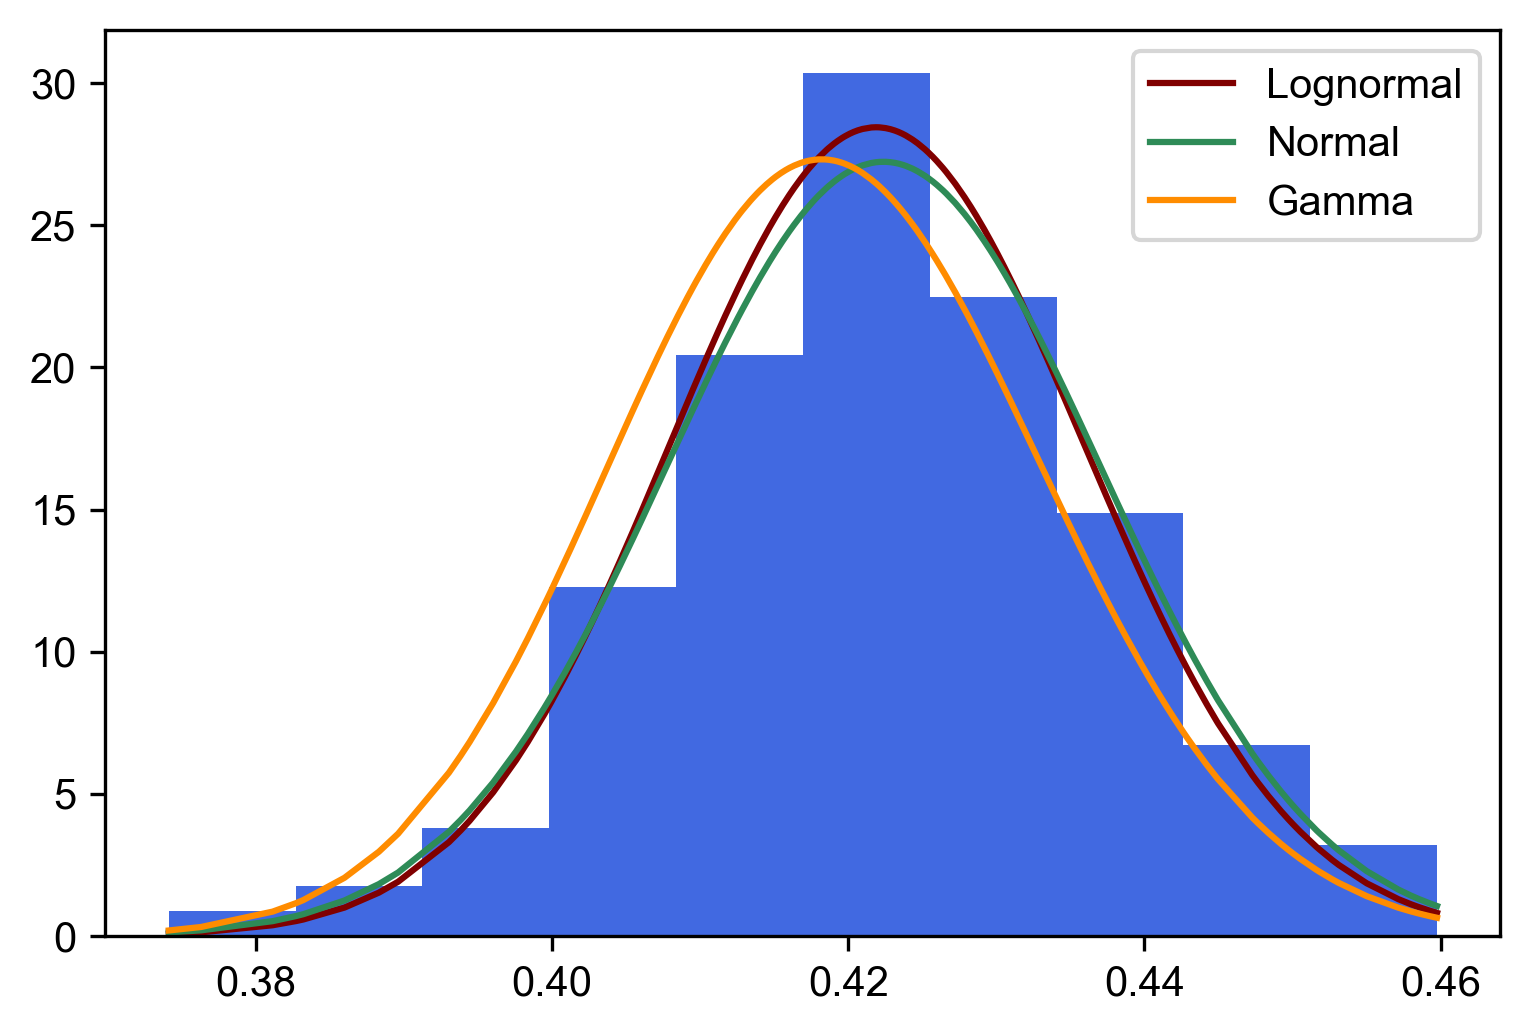

In [63]:
# Visualize the relative frequency histogram darkorange
plt.hist(Sampleset, density=True, color='royalblue')
Pdffit1 = stats.distributions.lognorm.pdf(Sval, 0.009, -1.136, 1.558)
Pdffit2 = stats.distributions.norm.pdf(Sval, Miu, Sig)
Pdffit3 = stats.distributions.gamma.pdf(Sval, 593, 0.063, 0.0006)
plt.plot(Sval, Pdffit1, color='maroon', label='Lognormal')
plt.plot(Sval, Pdffit2, color='seagreen', label='Normal')
plt.plot(Sval, Pdffit3, color='darkorange', label='Gamma')
plt.legend()
plt.rcParams['figure.figsize'] = (6, 4) 
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300 
plt.savefig(r"%s.jpg"%('FREQ'), bbox_inches='tight')
plt.show()

In [49]:
import scipy.stats as st
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "beta", "weibull_min", "lognorm", "gamma"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [50]:
BD, BP, PA = get_best_distribution(Sampleset)

p value for norm = 0.8909393993388457
p value for exponweib = 0.7075854952361653
p value for beta = 0.6485085992409462
p value for weibull_min = 3.2413804728859033e-197
p value for lognorm = 0.906092843011787
p value for gamma = 0.7215158434307162
Best fitting distribution: lognorm
Best p value: 0.906092843011787
Parameters for the best fit: (0.00938866108205888, -1.1361541425642123, 1.5585047321615195)


In [58]:
dist_name = "gamma"
dist = getattr(st, dist_name)

In [59]:
param = dist.fit(Sampleset)
param

(592.9656218060759, 0.06371139731316067, 0.0006047307421368129)

In [60]:
D, p = st.kstest(Sampleset, dist_name, args=param)
print(D, p)

0.03428429365428681 0.7215158434307162
